In [1]:
import torch
import numpy as np   

In [2]:
def get_randmask(observed_mask, sample_ratio):
        rand_for_mask = torch.rand_like(observed_mask) * observed_mask
        rand_for_mask = rand_for_mask.reshape(len(rand_for_mask), -1)
        for i in range(len(observed_mask)):
            # sample_ratio = 0.2 * np.random.rand()
            sample_ratio = sample_ratio
            num_observed = observed_mask[i].sum().item()
            num_masked = round(num_observed * sample_ratio)
            rand_for_mask[i][rand_for_mask[i].topk(num_masked).indices] = -1
        cond_mask = (rand_for_mask > 0).reshape(observed_mask.shape).float()
        return cond_mask

In [3]:
import sys
import os
sys.path.insert(0, "/home/mafzhang/code/CHLA-Imputation-and-Prediction-for-Bay/")
print(sys.path)
from dataset.dataset_imputation import PRE8dDataset

['/home/mafzhang/code/CHLA-Imputation-and-Prediction-for-Bay/', '/home/mafzhang/miniconda3/envs/torch/lib/python39.zip', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/mafzhang/.local/lib/python3.9/site-packages', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9/site-packages']


In [4]:
import argparse
parser = argparse.ArgumentParser(description='Imputation')

# args for area and methods
parser.add_argument('--area', type=str, default='PRE', help='which bay area we focus')

# basic args
parser.add_argument('--epochs', type=int, default=500, help='epochs')
parser.add_argument('--batch_size', type=int, default=16, help='batch size')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
parser.add_argument('--wd', type=float, default=1e-4, help='weight decay')
parser.add_argument('--test_freq', type=int, default=500, help='test per n epochs')
parser.add_argument('--embedding_size', type=int, default=32)
parser.add_argument('--hidden_channels', type=int, default=32)
parser.add_argument('--diffusion_embedding_size', type=int, default=64)
parser.add_argument('--side_channels', type=int, default=1)

# args for tasks
parser.add_argument('--in_len', type=int, default=46)
parser.add_argument('--out_len', type=int, default=46)
parser.add_argument('--missing_ratio', type=float, default=0.1)

# args for diffusion
parser.add_argument('--beta_start', type=float, default=0.0001, help='beta start from this')
parser.add_argument('--beta_end', type=float, default=0.2, help='beta end to this')
parser.add_argument('--num_steps', type=float, default=50, help='denoising steps')
parser.add_argument('--num_samples', type=int, default=10, help='n datasets')
parser.add_argument('--schedule', type=str, default='quad', help='noise schedule type')
parser.add_argument('--target_strategy', type=str, default='random', help='mask')

# args for mae
parser.add_argument('--num_heads', type=int, default=8, help='n heads for self attention')
config = parser.parse_args([])

In [5]:
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=True)

In [6]:
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

In [7]:
model = torch.load("../../log/imputation/PRE/GraphDiffusion/best_0.1.pt")
model = model.to(device)

In [8]:
cond_mask = get_randmask(data_ob_masks, 0.1)
cond_mask = cond_mask.to(device)
adj = np.load("/home/mafzhang/data/{}/8d/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

In [9]:
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0,0:4][mask.bool().cpu()[0,0:4]]
truth = datas[0,0:4][mask.bool()[0,0:4]].cpu()

In [10]:
mae = torch.load("../../log/imputation/PRE/MAE/best.pt")
is_sea = np.load("/home/mafzhang/data/PRE/8d/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]

In [11]:
imputed_mae = imputed_data_mae[0,0:4][mask.bool().cpu()[0,0:4]]

In [12]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

In [13]:
imputed_itp = imputed_data_itp[0,0:4][mask.bool().cpu()[0,0:4]]

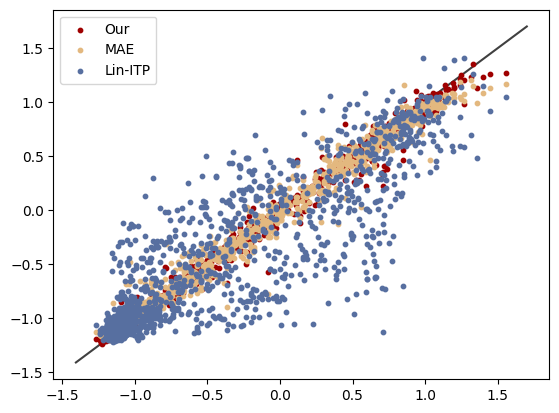

In [15]:
import matplotlib.pyplot as plt
plt.scatter(truth, imputed_our,s=10, c="#9F0000",label="Our")
plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=10, c="#e3b87f", label="MAE")
plt.scatter(truth, imputed_itp.cpu(),s=10, c="#576fa0", label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.legend()

In [47]:
cond_mask = get_randmask(data_ob_masks, 0.9)
cond_mask = cond_mask.to(device)

In [53]:
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0,0:1][mask.bool().cpu()[0,0:1]]
truth = datas[0,0:1][mask.bool()[0,0:1]].cpu()

In [54]:
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]
imputed_mae = imputed_data_mae[0,0:1][mask.bool().cpu()[0,0:1]]

In [55]:
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])
imputed_itp = imputed_data_itp[0,0:1][mask.bool().cpu()[0,0:1]]

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(truth, imputed_our,s=5, c="#9F0000", alpha=0.7,label="Our")
plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=5, c="#e3b87f", alpha=0.7,label="MAE")
plt.scatter(truth, imputed_itp.cpu(),s=5, c="#576fa0", alpha=0.7,label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.legend()